In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import random
from matplotlib import pyplot as plt
from pathlib import Path
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import csv
from csv import writer

# data preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size = 64
dataset = torchvision.datasets.ImageFolder(str(Path().absolute())+"\\train", transform=transform) 
trainset,testset = torch.utils.data.random_split(dataset, [0.8,0.2]) 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = [classess for classess in dataset.class_to_idx]

['acoustic', 'antenna', 'bacteria', 'battery', 'bean', 'beetle', 'bicycle', 'birch', 'bird', 'bomb', 'bread', 'bridge', 'camera', 'carbon', 'cat', 'corn', 'crab', 'crocodilian', 'echinoderm', 'egg', 'elephant', 'fish', 'flower', 'frog', 'fungus', 'gauge', 'hammer', 'icecream', 'kangaroo', 'memorial', 'monkey', 'motor', 'nest', 'palm', 'pizza', 'pot', 'printer', 'saw', 'snake', 'spice', 'spider', 'spoon', 'squash', 'swine', 'tea', 'tomato', 'towel', 'truck', 'turtle', 'worm']


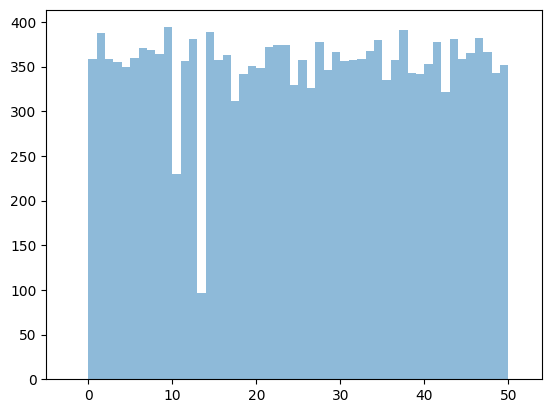

In [3]:
#Checking number of elements for each class in training dataset to make sure there are no big imbalances

datahist = [row[1] for row in testloader.dataset]

bins = np.arange(-50, 100, 1) 

plt.xlim([min(datahist)-5, max(datahist)+5])

plt.hist(datahist, bins=bins, alpha=0.5)
print(classes)
plt.show()

# convolutional neural network model

In [4]:
class Net(nn.Module):
    def __init__(self,input_neurons, layer1, layer2, layer3, layer4, layer5, layer6, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_neurons, out_channels=layer1, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(layer1)
        self.conv2 = nn.Conv2d(in_channels=layer1, out_channels=layer2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(layer2)
        self.conv3 = nn.Conv2d(in_channels=layer2, out_channels=layer3, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(layer3)
        self.conv4 = nn.Conv2d(in_channels=layer3, out_channels=layer4, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(layer4)
        self.conv5 = nn.Conv2d(in_channels=layer4, out_channels=layer5, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(layer5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(out_features=layer6)
        self.dropout = nn.Dropout(0.6)
        self.fc2 = nn.LazyLinear(out_features=num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x


# parameters

In [5]:
#net = Net(3,32,64,128,256,512,50)
net = Net(3,32,64,128,256,512,512,50)
#net = Net(3,512,256,128,64,32,16,8,50)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

device = torch.device("cuda")
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    net.to(device)


C:\Users\-\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# training and evaluation

In [6]:
#training
acc1 = 0.0
epoch = 0
for i in range(101):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    net.eval()
    print('%d epoch loss: %.3f' %(epoch+1 ,  running_loss / 2000))
    epoch+=1
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network: %d %%' % (100 * correct / total))
        
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data    
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

1 epoch loss: 1.761
Accuracy of the network: 31 %
2 epoch loss: 1.443
Accuracy of the network: 39 %
3 epoch loss: 1.303
Accuracy of the network: 42 %
4 epoch loss: 1.215
Accuracy of the network: 45 %
5 epoch loss: 1.145
Accuracy of the network: 47 %
6 epoch loss: 1.077
Accuracy of the network: 50 %
7 epoch loss: 1.005
Accuracy of the network: 50 %
8 epoch loss: 0.961
Accuracy of the network: 51 %
9 epoch loss: 0.918
Accuracy of the network: 53 %
10 epoch loss: 0.879
Accuracy of the network: 54 %
11 epoch loss: 0.840
Accuracy of the network: 53 %
12 epoch loss: 0.815
Accuracy of the network: 55 %
13 epoch loss: 0.781
Accuracy of the network: 55 %
14 epoch loss: 0.751
Accuracy of the network: 56 %
15 epoch loss: 0.723
Accuracy of the network: 55 %
16 epoch loss: 0.694
Accuracy of the network: 56 %
17 epoch loss: 0.668
Accuracy of the network: 56 %
18 epoch loss: 0.643
Accuracy of the network: 56 %
19 epoch loss: 0.613
Accuracy of the network: 57 %
20 epoch loss: 0.588
Accuracy of the net

In [7]:
#evaluation
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data    
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class acoustic is: 48.6 %
Accuracy for class antenna is: 58.2 %
Accuracy for class bacteria is: 57.1 %
Accuracy for class battery is: 54.6 %
Accuracy for class bean  is: 44.0 %
Accuracy for class beetle is: 70.3 %
Accuracy for class bicycle is: 68.5 %
Accuracy for class birch is: 52.3 %
Accuracy for class bird  is: 38.5 %
Accuracy for class bomb  is: 60.2 %
Accuracy for class bread is: 46.1 %
Accuracy for class bridge is: 59.0 %
Accuracy for class camera is: 69.6 %
Accuracy for class carbon is: 42.3 %
Accuracy for class cat   is: 51.4 %
Accuracy for class corn  is: 45.4 %
Accuracy for class crab  is: 28.9 %
Accuracy for class crocodilian is: 38.3 %
Accuracy for class echinoderm is: 39.2 %
Accuracy for class egg   is: 34.5 %
Accuracy for class elephant is: 77.9 %
Accuracy for class fish  is: 50.8 %
Accuracy for class flower is: 92.2 %
Accuracy for class frog  is: 44.9 %
Accuracy for class fungus is: 66.6 %
Accuracy for class gauge is: 55.2 %
Accuracy for class hammer is: 79

# Classify data with no labels

In [8]:
#Data preprocessing. Won't work on data with labels
from torch.utils.data import Dataset
import os
import natsort
import PIL
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)
        
    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = PIL.Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

ModuleNotFoundError: No module named 'natsort'

In [ ]:
preds_list=[]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = CustomDataSet("/test_all",transform)
trainloader = torch.utils.data.DataLoader(dataset,shuffle=False, num_workers=2)
filenames = dataset.total_imgs

loader = torch.utils.data.DataLoader(dataset,batch_size = len(dataset))
dataiter = iter(loader)

In [ ]:
#Data classification
with torch.no_grad(): 
        images = next(dataiter)
        data_inputs = images.to(device)
        preds = net(data_inputs)
        preds = preds.squeeze(dim=1)
        pred_labels=(torch.argmax(preds,dim=1).view(-1,1)).tolist()
        for i in range(len(pred_labels)):
          preds_list.append([filenames[i],pred_labels[i][0]])
        
print(preds_list)

In [ ]:
#Save data to csv
with open('/predictions.csv', 'w') as f_object:
 
    writer_object = writer(f_object)
 
    for i in range(0, len(preds_list)):
      writer_object.writerow(([preds_list[i][0],preds_list[i][1]]))
f_object.close()